# Radiomics analysis

In [381]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import fastcluster

from scipy import stats
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, f_classif

ds_path = "../study/stats/datasetRadiomics.csv"

In [124]:
df = pd.read_csv(ds_path, index_col="ID")

[roi_name]\_[metric]\_[image]\_[feature] 

In [204]:
def separateDFs(df):
    y1 = df["resp"]
    X = df.drop(["resp", "respPart"], axis=1)
    print(X.shape)

    a = X.isna().any(axis=0)
    # X1 is the first ds
    X1 = X.drop(a[a==True].index, axis=1)

    print(X1.shape)

    X2_1 = X.loc[:, a==True].drop("VNSLC_16")
    b = X2_1.isna().any(axis=0)
    # X2 is the second ds
    X2 = X2_1.drop(b[b==True].index, axis=1)
    y2 = y1.drop("VNSLC_16")
    print(X2.shape)

    # X3 is the third ds
    X3 = X2_1.loc[:, b==True].drop("VNSLC_19")
    y3 = y2.drop("VNSLC_19")
    print(X3.shape)

    return X1, y1, X2, y2, X3, y3

# Filtering

##### Variance threshold

In [205]:
X1, y1, X2, y2, X3, y3 = separateDFs(df)

(19, 1512456)
(19, 891272)
(18, 594176)
(17, 27008)


In [218]:
X_selected = []

for X in [X1, X2, X3]:
    varThresh = VarianceThreshold(0)
    varThresh.fit_transform(X)
    selected_feature_indices = varThresh.get_support(indices=True)
    X_selected.append(X.iloc[:, selected_feature_indices])

df_selected = pd.concat([df["resp"], df["respPart"], X_selected[0], X_selected[1], X_selected[2]], axis=1)

##### Outlier removal

In [258]:
z_scores_abs = abs((df_selected - df_selected.mean())/df_selected.std())

features_to_remove = []

for i in [0, 1, 2]:
    z_scores = z_scores_abs[df_selected["respPart"]==i]
    features_with_outliers = (z_scores > 1.65).any(axis=0)
    features_to_remove_curr = features_with_outliers[features_with_outliers == True].index

    features_to_remove = [*features_to_remove, *features_to_remove_curr]

df_outliers = df_selected.drop(features_to_remove, axis=1)

##### Kurtosis filtering

In [294]:
res = stats.kurtosis(df_outliers, axis=0, bias=False, nan_policy="omit")
df_kurtosis = df_outliers.iloc[:, (abs(res)<2)]

In [300]:
df_kurtosis.to_csv("../study/stats/datasetRadiomicsFiltered.csv")

In [2]:
df_kurtosis = pd.read_csv("../study/stats/datasetRadiomicsFiltered.csv", index_col="ID")

##### Mutual Information univariate filtering

In [367]:
X1, y1, X2, y2, X3, y3 = separateDFs(df_kurtosis)

(19, 47815)
(19, 30236)
(18, 17063)
(17, 516)


In [383]:
mu1_df = pd.DataFrame(mutual_info_classif(X1, y1), index=X1.columns)
mu2_df = pd.DataFrame(mutual_info_classif(X2, y2), index=X2.columns)
mu3_df = pd.DataFrame(mutual_info_classif(X3, y3), index=X3.columns)

KeyboardInterrupt: 

In [393]:
f1_df = pd.DataFrame(f_classif(X1, y1)[0], index=X1.columns)
f2_df = pd.DataFrame(f_classif(X2, y2)[0], index=X2.columns)
f3_df = pd.DataFrame(f_classif(X3, y3)[0], index=X3.columns)

In [388]:
mu1_df.T["Right-Putamen_wMD_wavelet-LLH_ngtdm_Complexity"]

0    0.545712
Name: Right-Putamen_wMD_wavelet-LLH_ngtdm_Complexity, dtype: float64

In [394]:
f1_df.sort_values(by=0)

,0
Right-Putamen_AD_wavelet-HHL_glszm_LowGrayLevelZoneEmphasis,0.000000
Right-Thalamus_icvf_wavelet-HHL_glszm_HighGrayLevelZoneEmphasis,0.000000
Right-Amygdala_fextra_wavelet-HLH_glszm_LowGrayLevelZoneEmphasis,0.000000
lh.ar_wfvf_wavelet-HHL_glszm_HighGrayLevelZoneEmphasis,0.000000
Left-Amygdala_wfvf_wavelet-HLH_glszm_HighGrayLevelZoneEmphasis,0.000000
...,...
Right-Amygdala_MD_lbp-3D-k_glrlm_LowGrayLevelRunEmphasis,25.910678
Right-Amygdala_MD_lbp-3D-k_glrlm_HighGrayLevelRunEmphasis,25.910678
lh.cbv_RD_wavelet-HHH_glszm_SmallAreaLowGrayLevelEmphasis,27.255341
Right-Putamen_wMD_wavelet-LLH_ngtdm_Complexity,39.054372


In [392]:
f1_df.sort_values(by=0)

,0
Left-Putamen_frac_csf_mf_gradient_firstorder_InterquartileRange,0.000006
Right-Putamen_wMD_wavelet-LLH_ngtdm_Complexity,0.000009
lh.cbv_RD_wavelet-HHH_glszm_SmallAreaLowGrayLevelEmphasis,0.000069
Right-Amygdala_MD_lbp-3D-k_glrlm_HighGrayLevelRunEmphasis,0.000091
Right-Amygdala_MD_lbp-3D-k_glrlm_LowGrayLevelRunEmphasis,0.000091
...,...
Right-Amygdala_fextra_wavelet-HLH_glszm_LowGrayLevelZoneEmphasis,1.000000
Right-Amygdala_fextra_wavelet-HLH_glszm_HighGrayLevelZoneEmphasis,1.000000
Right-Thalamus_icvf_wavelet-HHL_glszm_HighGrayLevelZoneEmphasis,1.000000
Right-Putamen_AD_wavelet-HHL_glszm_HighGrayLevelZoneEmphasis,1.000000


##### Mannwhiten

In [332]:
X_resp = df_kurtosis[df["resp"]==1]
X_non = df_kurtosis[df["resp"]==0]
res = pd.DataFrame(stats.mannwhitneyu(X_resp, X_non, nan_policy="omit").pvalue, index=df_kurtosis.columns)

In [360]:
res[res<0.05].dropna().sort_values(by=0)[::-1]

,0
rh.fat_wfvf_lbp-3D-k_glszm_GrayLevelVariance,0.049832
rh.fat_wfvf_lbp-3D-k_glszm_GrayLevelNonUniformityNormalized,0.049832
rh.slf3_odi_lbp-2D_firstorder_90Percentile,0.049436
lh.slf3_frac_csf_mf_lbp-3D-m1_firstorder_Median,0.048443
rh.cbv_AD_wavelet-LLH_glszm_LargeAreaHighGrayLevelEmphasis,0.047673
...,...
Right-Amygdala_MD_lbp-3D-k_glrlm_LowGrayLevelRunEmphasis,0.000159
Right-Amygdala_MD_lbp-3D-k_glrlm_HighGrayLevelRunEmphasis,0.000159
Left-Putamen_frac_csf_mf_gradient_firstorder_InterquartileRange,0.000159
Right-Putamen_wMD_wavelet-LLH_ngtdm_Complexity,0.000040


/home/michele/anaconda3/envs/pyRadiomics/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/michele/anaconda3/envs/pyRadiomics/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/michele/anaconda3/envs/pyRadiomics/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<AxesSubplot:xlabel='resp', ylabel='rh.fat_wfvf_lbp-3D-k_glszm_GrayLevelVariance'>

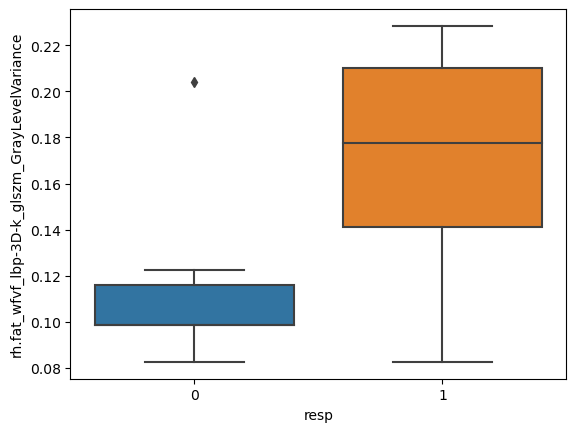

In [380]:
sns.boxplot(y=df_kurtosis["rh.fat_wfvf_lbp-3D-k_glszm_GrayLevelVariance"], x=df["resp"])

# Clustering by region

In [3]:
roi_name = [
    "Thalamus",
    "Hippocampus",
    "Amygdala",
    "Accumbens-area",
    "Putamen", 
    "Pallidum",
    "Caudate",
]

tract_name = [
    "acomm",
    "cc.bodyc",
    "cc.bodyp",
    "cc.bodypf",
    "cc.bodypm",
    "cc.bodyt",
    "cc.genu",
    "cc.rostrum",
    "cc.splenium",
    "lh.af",
    "lh.ar",
    "lh.atr",
    "lh.cbd",
    "lh.cbv",
    "lh.cst",
    "lh.emc",
    "lh.fat",
    "lh.fx",
    "lh.ilf",
    "lh.mlf",
    "lh.or",
    "lh.slf1",
    "lh.slf2",
    "lh.slf3",
    "lh.uf",
    "mcp",
    "lh.af",
    "rh.ar",
    "rh.atr",
    "rh.cbd",
    "rh.cbv",
    "rh.cst",
    "rh.emc",
    "rh.fat",
    "rh.fx",
    "rh.ilf",
    "rh.mlf",
    "rh.or",
    "rh.slf1",
    "rh.slf2",
    "rh.slf3",
    "rh.uf",
    "mcp"
]

In [4]:
def getDF(df, feature):
    df_filtered = df.filter(regex=feature)
    areNaN = df_filtered.isna().any(axis=1)
    to_remove = areNaN[areNaN == True].index
    return df_filtered.drop(to_remove), to_remove

In [40]:
lut = dict(zip([0, 1, 2], "ryg"))
row_colors = df_kurtosis["respPart"].map(lut)

image_types = {
    "original"      : "blue",
    "exponential"   : "orange",
    "gradient"      : "green",
    "lbp-2D"        : "red",
    "lbp-3D"        : "purple",
    "log"           : "brown",
    "logarithm"     : "pink",
    "square"        : "gray",
    "squareroot"    : "olive",
    "wavelet"       : "cyan"
}

def mapping_func(v):
    for image_type in lut.keys():
        if image_type in v:
            return lut[image_type]
    return "k"

lut = image_types
col_colors_image = pd.DataFrame(df_kurtosis.columns.map(mapping_func)).T
col_colors_image.columns = df_kurtosis.columns
col_colors_image = col_colors_image

metrics = {
    "FA"    : "red",
    "AD"    : "yellow",
    "RD"    : "yellow",
    "MD"    : "yellow",
    "icvf"  : "aquamarine",
    "odi"   : "red",
    "fextra": "blue",
    "fintra": "blue",
    "fiso"  : "green" ,
    "wFA"   : "red",
    "wMD"   : "yellow",
    "wAD"   : "yellow",
    "wRD"   : "yellow",
    "frac_csf": "green",
    "wfvf"  : "red",
    "fvf_tot": "red",
    "frac_csf":"green",
}

lut = metrics
col_colors_metrics = pd.DataFrame(df_kurtosis.columns.map(mapping_func)).T
col_colors_metrics.columns = df_kurtosis.columns
col_colors_metrics = col_colors_metrics

col_colors = pd.concat([col_colors_image, col_colors_metrics], axis=0, ignore_index=True)
col_colors.index = ["image_type", "model_type"]

In [39]:
method = "average"

if not os.path.isdir(f"../imgs/clustering/roi/"):
    os.mkdir(f"../imgs/clustering/roi/")

if not os.path.isdir(f"../imgs/clustering/roi/{method}/"):
    os.mkdir(f"../imgs/clustering/roi/{method}/")

for mask in roi_name:
    for side in ["Left", "Right"]:
        # print(side, mask)

        regex = f"{side}-{mask}"
        df, to_remove = getDF(df_kurtosis, regex)
        col_colors_filtered = col_colors.filter(regex=regex).T

        sns.clustermap(df, row_colors=row_colors.drop(to_remove), col_colors=col_colors_filtered, z_score=1, method=method, robust=True, cbar_pos=None, xticklabels=False)
        plt.savefig(f"../imgs/clustering/{method}/{mask}-{side}-{method}.png")

        del df
        del col_colors_filtered
        plt.close()

for mask in tract_name:
    # print(mask)

    regex = f"{mask}"
    df, to_remove = getDF(df_kurtosis, regex)
    col_colors_filtered = col_colors.filter(regex=regex).T

    sns.clustermap(df, row_colors=row_colors.drop(to_remove), col_colors=col_colors_filtered, z_score=1, method=method, robust=True, cbar_pos=None, xticklabels=False)
    mask_fields = mask.split(".")
    if len(mask_fields) == 1:
        plt.savefig(f"../imgs/clustering/{method}/{mask}-{method}.png")
    else:
        plt.savefig(f"../imgs/clustering/{method}/{mask_fields[1]}-{mask_fields[0]}-{method}.png")

    del df
    del col_colors_filtered
    plt.close()

/home/michele/anaconda3/envs/pyRadiomics/lib/python3.9/site-packages/seaborn/matrix.py:615: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, max_dependent_coord * 1.05)


ValueError: negative dimensions are not allowed

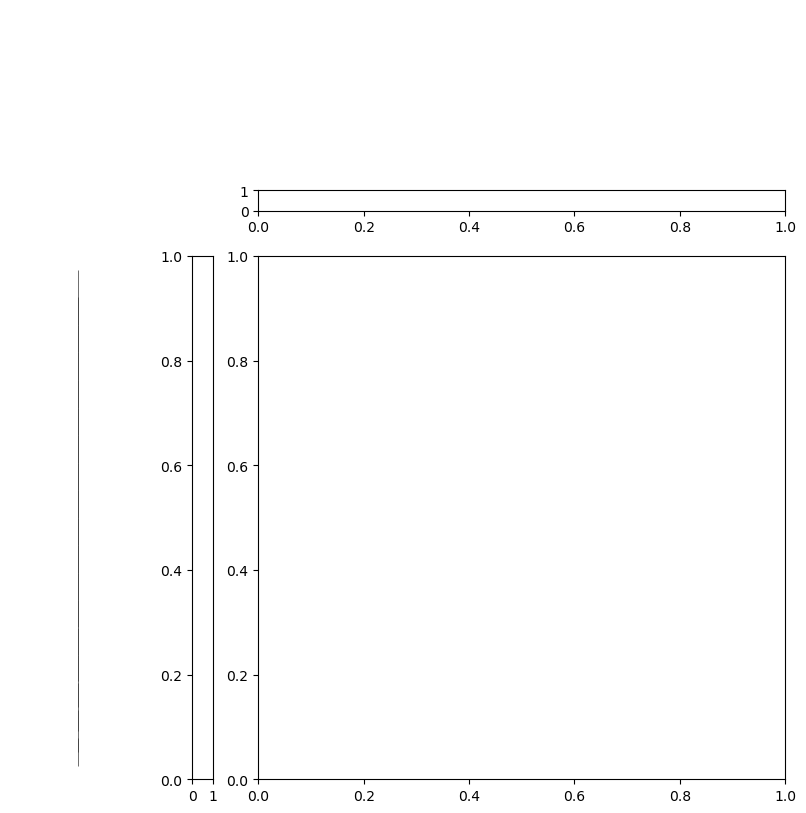

In [45]:
method = "average"

if not os.path.isdir(f"../imgs/clustering/metrics/"):
    os.mkdir(f"../imgs/clustering/metrics/")

if not os.path.isdir(f"../imgs/clustering/metrics/{method}/"):
    os.mkdir(f"../imgs/clustering/metrics/{method}/")

for metric in metrics.keys():
    for image_type in image_types.keys():
        regex = f"{metric}_{image_type}"
        df, to_remove = getDF(df_kurtosis, regex)
        col_colors_filtered = col_colors.filter(regex=regex).T

        sns.clustermap(df, row_colors=row_colors.drop(to_remove), col_colors=col_colors_filtered, z_score=1, method=method, robust=True, cbar_pos=None, xticklabels=False)

        plt.savefig(f"../imgs/clustering/metrics/{method}/{metric}_{image_type}.png")
        
        del df
        del col_colors_filtered
        plt.close()